# Latent Class Analysis (LCA) on Survey Data

In this notebook wre will use Latent Class Analysis (LCA) as opposed to K-Means and K-Modes.

### Installation & Set up

`!pip install stepmix`

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from stepmix.stepmix import StepMix

import matplotlib.pyplot as plt
%matplotlib inline

### First define some helper functions (these copied from the `initial_eda_and_feature_engineering.ipynb` notebook)

In [2]:
def age_ranges(x):
    "To be called through Pandas Apply, to map an Age integer to a binned string"
    res = "Unknown"
    if x < 18: res = "Adolescent"
    if x >= 18 and x < 40: res = "Adult"
    if x >= 40 and x < 60: res = "Middle aged"
    if x >= 60 and x < 70: res = "Senior citizens"
    if x >= 71: res = "Elderly"
    return res

def load_data(cols=[]):
    "Perform all the preprocessing steps we identified in the initial_eda_and_feature_engineering.ipynb notebook"
    df = pd.read_csv('survey.csv')

    # So it seems Gender was a free text field and as such is pretty noise. But every row has a value, which is good. There are some obvious fixes:
    # Male, male, M, m, Make, Male (with a space at the end), msle, Mail, Malr, maile, Mal, Cis Male, cis male, Cis Man, Male (CIS) are all 'M'
    # Female, female, F, f, Woman, Female (with a space at the end), femail, Femake, woman, Female (cis), cis-female/femme, Cis Female are all 'F'
    # For simplicity of this exercise I will group all others as 'Other'
    # NOTE: I am a strong supporter of LGBTQ+ rights and such please do not consider this simplification above as anything more for demonstration purposes for this project.
    for gender in ['Male', 'male', 'M', 'm', 'Make', 'Male ', 'msle', 'Mail', 'Malr', 'maile', 'Mal', 'Cis Male', 'cis male', 'Cis Man', 'Male (CIS)', 'Man']:
        df.loc[df['Gender'] == gender, 'Gender'] = 'Male'

    for gender in ['Female', 'female', 'F', 'f', 'Woman', 'Female ', 'femail', 'Femake', 'woman', 'Female (cis)', 'cis-female/femme', 'Cis Female']:
        df.loc[df['Gender'] == gender, 'Gender'] = 'Female'

    df['Gender'] = df['Gender'].apply(lambda x: 'Other' if x not in ['Male', 'Female'] else x)
    
    # A quick look at `comments` shows some interesting info there that could be used in a follow up experiment, but for now I will disregard the `comments` field.
    df.drop('comments', axis=1, inplace=True)

    # Let's look at 'state' first:
    # OK that largely makes sense, right, that the countries are non-US and so seemingly in this data are not using State or a State equivalent.
    # For simplicity lets fill the `nan` US ones with 'CA'.
    df.loc[(df['state'].isna()) & (df['Country'] == 'United States'), 'state'] = df['state'].mode()[0]

    # And set the rest (non-US) to 'N/A'

    df['state'] = df['state'].fillna("N/A")

    # Good, ok let's move on to `self employed`.
    # Interestingly the 18 records that do not have `self_employed` filled are the first 18 in the data_set, so maybe this was not asked fromt eh start.
    # Let's just set them to the mode of the `self_employed` column.
    df.loc[df['self_employed'].isna(), 'self_employed'] = df['self_employed'].mode()[0]

    # So finally, let's look at `work_interfere`.
    # It seems the middle of the road value of 'Sometimes' was the most answer, so let's just use that.
    df.loc[df['work_interfere'].isna(), 'work_interfere'] = df['work_interfere'].mode()[0]

    # Let's bin Age into something categorical.
    df['Age'] = df['Age'].apply(age_ranges)

    # Finally I think we can lose the `TimeStamp'.
    df.drop('Timestamp', axis=1, inplace=True)

    # Filter to just the selected columns
    if len(cols) > 0: df = df[cols]
    
    # separate continuous and categorical variable columns
    # (Although this is boilerplate I use and not really relevant as we have binned the only numerical column ('Age'))
    continuous_vars = [col for col in df.columns if df[col].dtype != 'object']
    categorical_vars = [col for col in df.columns if df[col].dtype == 'object']
    
    if len(continuous_vars) > 0:
        # Scaling is important for K-Means because K-Means is a distance-based algorithm that clusters data points based on their Euclidean distance from a centroid. If the features in the dataset are not scaled, some of them may be given higher weights than others, which can result in clustering biases towards features with larger magnitudes. This can lead to poor cluster assignments and reduced accuracy
        scaler = MinMaxScaler()
        df_con[continuous_vars] = pd.DataFrame(scaler.fit_transform(df[continuous_vars]))
    else:
        df_con = pd.DataFrame()
    
    if len(categorical_vars) > 0:
        df_cat = pd.get_dummies(df, columns=categorical_vars)
    else:
        df_cat = pd.DataFrame()
        
    df_preprocessed = pd.concat([df_con, df_cat], axis=1)
    
    return df, df_preprocessed

### And then some others

In [3]:
def show_clusters(df_ca, df, col='predicted_cluster'):
    "Simply output the contents of the dataframe per Cluster to see those grouped together"
#     for cluster_number in range(len(df_ca[col].unique())):
    for cluster_number in range(max(df_ca[col]) + 1):

        idx = df_ca[df_ca[col] == cluster_number].index

        print('Cluster', str(cluster_number))
        display(df.iloc[idx])

In [4]:
def show_lca(model, n_clusters, classes=[]):
    # Plot the results 
    fig = plt.figure(figsize=(8, 8))

    x_range = range(int(model.get_parameters()['measurement']['total_outcomes']  / 2))

    # for i, values in enumerate(model.get_parameters()['measurement']['pis']):
        # plt.plot(x_range, np.array(list(values)[::2]), label=f'Class {i}')

    if len(classes) == 0: classes = ['Class '+str(i) for i in range(n_clusters)]
    for cls in classes: #:
        plt.plot(x_range, np.array(list(model.get_parameters()['measurement']['pis'][int(cls[-1])][::2])), label=cls)

    # Add grid lines 
    plt.grid(True)  

    # Add a legend
    plt.legend()  

    # Add x-axis and y-axis labels
    plt.xlabel('Question and Answer')
    plt.ylabel('Question Relevancy') 

    # Add the ticks
    plt.xticks(range(len(model.feature_names_in_)), model.feature_names_in_, rotation=90, fontsize=8)
    plt.yticks([0, 1], ['Relevant', 'Not Relevant'])

    plt.show()

### Then load the data and limit to the questions we want

In [5]:
df, df_preprocessed = load_data(['Age', 'Gender'])

## Let's do some Latent Class Analysis

LCA, simply put, is a statistical technique used to identify subgroups (or latent classes) within a larger population, based on patterns of responses to a set of categorical variables.

LCA assumes that the underlying latent classes are unobservable, and their membership can only be inferred based on observed responses to various items.

The LCA models aim to identify the optimal number of latent classes, and to estimate the probability of each individual belonging to each class, given his/her response pattern. The models generate a set of estimated probabilities for each person's membership in each class.

So Let's give it a go...

Let's start with a guess at 3 classes (components) for 1 iteration (step).

In [6]:
model = StepMix(n_components=3, n_steps=1, measurement="categorical", verbose=1, progress_bar=0, random_state=42)

# Fit model and predict clusters
model.fit(df_preprocessed)
clusters = model.predict(df_preprocessed)
clusters

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 8 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 1.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 0.0000 1.0000 1.0000 0.0000]
        Class 2 : [1.0000 0.0000 0.0000 1.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 0.0714 0.9286 1.0000 0.0000 0.9286 0.0714]
        Class 3 : [0.9683 0.0317 1.0000 0.0000 0.9841 0.0159 0.0741 0.9259 0.9735 0.0265
 0.8624 0.1376 0.1640 0.8360 0.9735 0.0265]
    Class weights
        Class 1 : 0.66
        Class 2 : 0.19
        Class 3 : 0.15
    Fit for 3 latent classes
    Estimation method             : 1-step
    Number of observatio

array([1, 2, 0, ..., 0, 2, 0], dtype=int64)

OK so that has done something, but can we see what?

In [7]:
# What are the features used and parameters generated?
model.feature_names_in_

array(['Age_Adolescent', 'Age_Adult', 'Age_Elderly', 'Age_Middle aged',
       'Age_Senior citizens', 'Gender_Female', 'Gender_Male',
       'Gender_Other'], dtype=object)

In [8]:
# What about the parameters of each of those features
model.get_parameters()

{'weights': array([0.6608, 0.1890, 0.1501]),
 'measurement': {'max_n_outcomes': 2,
  'total_outcomes': 16,
  'pis': array([[1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
          1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
          1.0000, 0.0000, 0.0714, 0.9286, 1.0000, 0.0000, 0.9286, 0.0714],
         [0.9683, 0.0317, 1.0000, 0.0000, 0.9841, 0.0159, 0.0741, 0.9259,
          0.9735, 0.0265, 0.8624, 0.1376, 0.1640, 0.8360, 0.9735, 0.0265]])},
 'measurement_in': 8}

In [9]:
model.get_parameters()['measurement']['pis'][0]

array([1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
       1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000])

After a bit of reading around I can see that it's every other parameter I want for the y-axis

In [10]:
np.array(list(model.get_parameters()['measurement']['pis'][0][::2]))

array([1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000])

So this can give me something like this, for a single class:

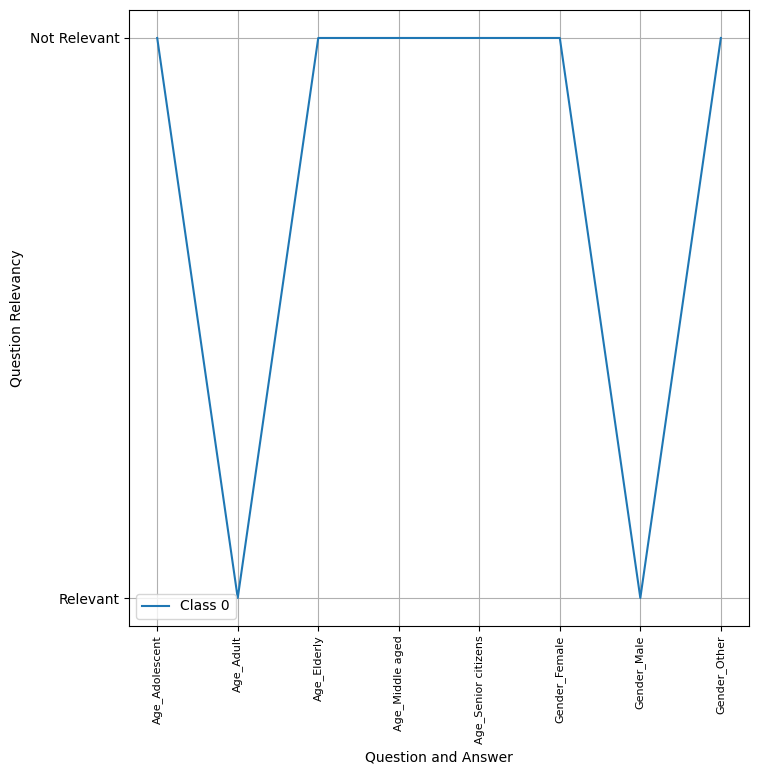

In [11]:
show_lca(model, 3, ['Class 0'])

Awesome, so we can see the line 'point to' the question / answer pair that influenced it.

### Let's put it all together

Including a Grid Search to find some best parameters. We will use the AIC (Akaike Information Criterion). It is a widely used measure of goodness of fit for statistical models, like LCA, that attempts to balance model fit with model parsimony. Specifically, the AIC score for a model represents a trade-off between the model's deviation from the data and the number of parameters used to explain the data.

### Using AIC determined best Cluster Size of 8
{'weights': array([0.1755, 0.0079, 0.1176, 0.0135, 0.1650, 0.3127, 0.1831, 0.0246]), 'measurement': {'max_n_outcomes': 2, 'total_outcomes': 16, 'pis': array([[1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000],
       [0.6000, 0.4000, 1.0000, 0.0000, 0.9000, 0.1000, 1.0000, 0.0000,
        0.5000, 0.5000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
       [1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
       [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
       [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000],
       [1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
    

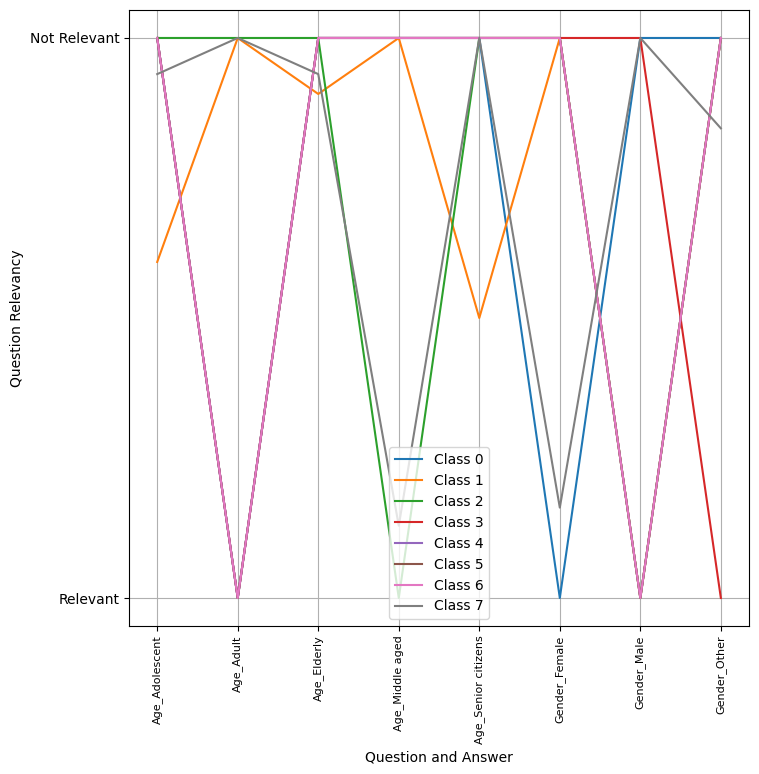

Show the Cluster Data
Cluster 0


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster
0,False,True,False,False,False,True,False,False,0
6,False,True,False,False,False,True,False,False,0
15,False,True,False,False,False,True,False,False,0
27,False,True,False,False,False,True,False,False,0
45,False,True,False,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...
1212,False,True,False,False,False,True,False,False,0
1225,False,True,False,False,False,True,False,False,0
1227,False,True,False,False,False,True,False,False,0
1230,False,True,False,False,False,True,False,False,0


Cluster 1


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster
143,True,False,False,False,False,False,True,False,1
297,False,False,False,False,True,False,True,False,1
364,False,False,True,False,False,False,True,False,1
520,False,False,False,False,True,False,True,False,1
560,False,False,False,False,True,False,True,False,1
715,True,False,False,False,False,False,True,False,1
734,True,False,False,False,False,False,True,False,1
952,False,False,False,False,True,False,True,False,1
1090,True,False,False,False,False,False,True,False,1
1236,False,False,False,False,True,False,True,False,1


Cluster 2


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster
1,False,False,False,True,False,False,True,False,2
18,False,False,False,True,False,False,True,False,2
22,False,False,False,True,False,False,True,False,2
23,False,False,False,True,False,False,True,False,2
33,False,False,False,True,False,False,True,False,2
...,...,...,...,...,...,...,...,...,...
1190,False,False,False,True,False,False,True,False,2
1211,False,False,False,True,False,False,True,False,2
1217,False,False,False,True,False,False,True,False,2
1220,False,False,False,True,False,False,True,False,2


Cluster 3


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster
55,False,True,False,False,False,False,False,True,3
72,False,True,False,False,False,False,False,True,3
93,False,True,False,False,False,False,False,True,3
306,False,True,False,False,False,False,False,True,3
349,False,True,False,False,False,False,False,True,3
387,False,True,False,False,False,False,False,True,3
413,False,True,False,False,False,False,False,True,3
416,False,True,False,False,False,False,False,True,3
544,False,True,False,False,False,False,False,True,3
553,False,True,False,False,False,False,False,True,3


Cluster 4


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster


Cluster 5


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster
2,False,True,False,False,False,False,True,False,5
3,False,True,False,False,False,False,True,False,5
4,False,True,False,False,False,False,True,False,5
5,False,True,False,False,False,False,True,False,5
7,False,True,False,False,False,False,True,False,5
...,...,...,...,...,...,...,...,...,...
1253,False,True,False,False,False,False,True,False,5
1254,False,True,False,False,False,False,True,False,5
1255,False,True,False,False,False,False,True,False,5
1256,False,True,False,False,False,False,True,False,5


Cluster 6


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster


Cluster 7


,Age_Adolescent,Age_Adult,Age_Elderly,Age_Middle aged,Age_Senior citizens,Gender_Female,Gender_Male,Gender_Other,predicted_cluster
8,False,False,False,True,False,True,False,False,7
12,False,False,False,True,False,True,False,False,7
34,False,False,False,True,False,True,False,False,7
101,False,False,False,True,False,True,False,False,7
178,False,False,False,True,False,True,False,False,7
210,False,False,False,True,False,True,False,False,7
390,False,False,True,False,False,False,False,True,7
391,False,False,False,True,False,True,False,False,7
451,False,False,False,True,False,False,False,True,7
469,False,False,False,True,False,True,False,False,7


In [12]:
# Scikit-Learn grid search object. We test n_classes from 1 to 8.
# We also add 1-step, 2-step and 3-step to the grid.
# We use 3 validation folds.
# We therefore fit a total of  8x3x3=72 estimators.
grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8],
    'n_steps' : [1, 2, 3]
}

model = StepMix(n_components=3, n_steps=1, measurement='categorical', verbose=0, progress_bar=0, random_state=123)

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])

# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(df_preprocessed)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(df_preprocessed))
    results['bic'].append(model.bic(df_preprocessed))

# Save results to a dataframe
results = pd.DataFrame(results)

n_clusters = int(results.loc[results['aic'].idxmin()]['param_n_components'])
n_steps = int(results.loc[results['aic'].idxmin()]['param_n_steps'])

print(f'### Using AIC determined best Cluster Size of {n_clusters}')

# Categorical StepMix Model with n_clusters latent classes
model = StepMix(n_components=n_clusters, n_steps=n_steps, measurement="categorical", verbose=0, progress_bar=0, random_state=123)
# Fit model and predict clusters
model.fit(df_preprocessed)
clusters = model.predict(df_preprocessed)

print(model.get_parameters())

df_preprocessed['predicted_cluster'] = clusters
df_ca = pd.DataFrame({'predicted_cluster': clusters})

print('Show the LCA results')
show_lca(model, n_clusters)

print('Show the Cluster Data')
show_clusters(df_ca, df_preprocessed) 

## Fantastic !!!

We can see the questions / answers that were relevant to each cluster, including the degree of relevance.

## Next step pull the whole lot together in a Streamlit App: `streamlit_clustering.py`